## Importing Neccessary modules

In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from time import time
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from nltk.sentiment import SentimentIntensityAnalyzer as sia
from sklearn.ensemble import StackingClassifier
#from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, mean_squared_error
from statsmodels.tsa.statespace.tools import diff
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

## Original import file

In [3]:
path="Final_Video_Games_data.csv" ## <-- Mention path here alone
original=pd.read_csv(path)
original.dropna(inplace=True)

## NLP data

In [4]:
t=time()
games=original.copy()
games.drop(['reviewTime',"asin",'reviewerID','reviewerName','verified','image_uploaded','reviewText','summary'],axis=1,inplace=True)
games.head(3)

,overall,review,Number_of_Words_in_review,Sentiment,category,description,title,brand,rank,main_cat,price,compound
0,4,good game good graphics a bit of a learning cu...,26,positive,video games pc games,anno 2070brand new in stockdvd rom software fo...,Anno 2070,ubisoft,30230.0,Video Games,7.95,0.4215
1,1,if you buy this game you will regret it if you...,99,negetive,video games pc games,anno 2070brand new in stockdvd rom software fo...,Anno 2070,ubisoft,30230.0,Video Games,7.95,-0.7351
2,5,this game is a bit hard to get the hang of but...,25,positive,video games pc games,anno 2070brand new in stockdvd rom software fo...,Anno 2070,ubisoft,30230.0,Video Games,7.95,0.7684


In [5]:
final=games.copy()

## Sentiment analysis

In [6]:
stop_words= set(stopwords.words('english'))
final['review_clean'] = final['review'].progress_apply(lambda x: ' '.join([item for item in x.split() if (item not in stop_words) and (item.isalnum())]))

100%|██████████| 55229/55229 [00:01<00:00, 27945.76it/s]


In [7]:
vader=sia()

In [8]:
final['compound'] = final['review'].progress_apply(lambda x: vader.polarity_scores(x)['compound'])

100%|██████████| 55229/55229 [01:33<00:00, 588.54it/s] 


In [9]:
final.loc[final['compound'] > 0.1, 'Sentiment'] = 'positive'
final.loc[(final['compound'] <= 0.1) & (final['compound'] > -0.1), 'Sentiment'] = 'neutral'
final.loc[final['compound'] <= -0.1, 'Sentiment'] = 'negative'

In [10]:
final.head()

,overall,review,Number_of_Words_in_review,Sentiment,category,description,title,brand,rank,main_cat,price,compound,review_clean
0,4,good game good graphics a bit of a learning cu...,26,positive,video games pc games,anno 2070brand new in stockdvd rom software fo...,Anno 2070,ubisoft,30230.0,Video Games,7.95,0.9153,good game good graphics bit learning curve arr...
1,1,if you buy this game you will regret it if you...,99,negative,video games pc games,anno 2070brand new in stockdvd rom software fo...,Anno 2070,ubisoft,30230.0,Video Games,7.95,-0.9341,buy game regret change major component compute...
2,5,this game is a bit hard to get the hang of but...,25,positive,video games pc games,anno 2070brand new in stockdvd rom software fo...,Anno 2070,ubisoft,30230.0,Video Games,7.95,0.9201,game bit hard get hang great great
3,3,seems like it would be an interesting game but...,58,positive,video games pc games,anno 2070brand new in stockdvd rom software fo...,Anno 2070,ubisoft,30230.0,Video Games,7.95,0.8555,seems like would interesting game computer wri...
4,4,i played it a while but it was alright the ste...,76,positive,video games pc games,anno 2070brand new in stockdvd rom software fo...,Anno 2070,ubisoft,30230.0,Video Games,7.95,0.9065,played alright steam bit trouble move game ste...


Text(0.5, 1.0, 'Sentiment')

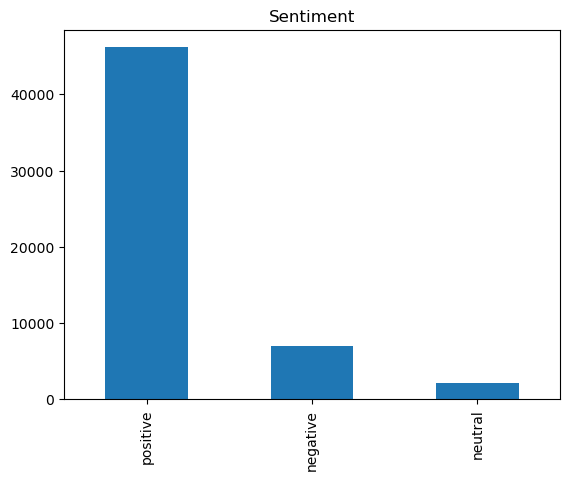

In [11]:
final.Sentiment.value_counts().plot(kind='bar')
plt.title('Sentiment')

In [12]:
nlp_clean=final.copy()

## Stacked models of NB and LogisticRegression

In [13]:
nb_model=MultinomialNB()
logreg_model=LogisticRegression(max_iter=1000)

stacked_model=StackingClassifier(estimators=[('nb', nb_model), ('logreg', logreg_model)],
    final_estimator=LogisticRegression(max_iter=1000))


## Train test split

In [14]:
xtrain,xtest,ytrain,ytest=train_test_split(final.review,final.Sentiment,test_size=0.2,random_state=22)

## Vectorizing

In [15]:
vectorizer=TfidfVectorizer()
xtraintf=vectorizer.fit_transform(xtrain)
xtesttf=vectorizer.transform(xtest)

## Model training

In [16]:
stacked_model.fit(xtraintf, ytrain)
y_pred=stacked_model.predict(xtesttf)

## Classification Model prediction and evaluation

In [17]:
accuracy = accuracy_score(ytest, y_pred)
precision = precision_score(ytest, y_pred,average='weighted',zero_division=1)
recall = recall_score(ytest, y_pred,average='weighted')
f1 = f1_score(ytest, y_pred,average='weighted')


print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

Accuracy: 0.9141770776751765
Precision: 0.907289391439362
Recall: 0.9141770776751765
F1 score: 0.907511373112923


## Wordcloud building

In [18]:
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer

reviews = final['review']


analyzer = SentimentIntensityAnalyzer()


# Generate a list of (word, sentiment score) tuples for each review
positive=[]
negative=[]


for review in tqdm(reviews):
    compound_score = analyzer.polarity_scores(review)['compound']
    if compound_score > 0.8:
        positive.append(review)
    elif compound_score < -0.3:
        negative.append(review)

100%|██████████| 55229/55229 [01:50<00:00, 501.86it/s] 


In [19]:
def sizer(sentence):
    sentence=" ".join(item for item in sentence.split(" ") if(len(item)>=4))
    return sentence

positive=[sizer(item) for item in positive]
negative=[sizer(item) for item in negative]

In [20]:
from collections import Counter
from autocorrect import Speller
from tqdm import tqdm

def corpus_create(reviews, emotion):
    senti = sia()
    spell = Speller(lang='en')
    notebook = Counter(spell(word.lower()) for review in tqdm(reviews, desc='Processing reviews') for word in review.split() if senti.polarity_scores(word)[emotion] == 1)
    return notebook



positive_words=corpus_create(positive,'pos')
negative_words=corpus_create(negative,'neg')

Processing reviews: 100%|██████████| 5874/5874 [01:37<00:00, 60.37it/s] 


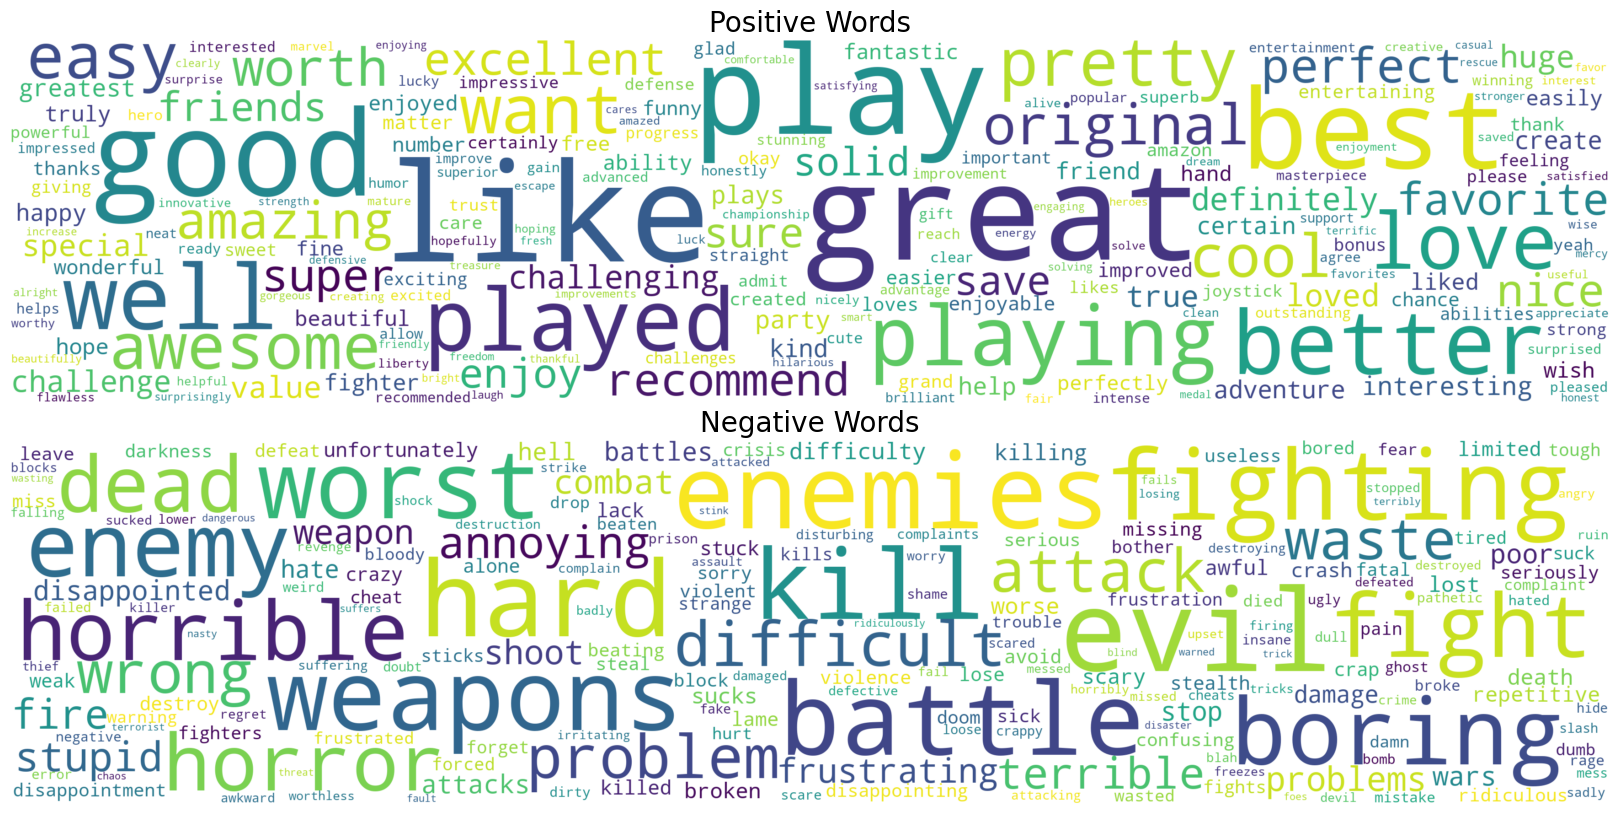

In [21]:
wordcloud = WordCloud(width=3500, height=800, max_font_size=300, background_color='white',
                      colormap='viridis', prefer_horizontal=1.0,
                      contour_width=3, contour_color='white',
                      ).generate_from_frequencies(frequencies=positive_words)

wordcloud_neg = WordCloud(width=3500, height=800, max_font_size=250, background_color='white',
                          colormap='viridis', prefer_horizontal=1.0,
                          contour_width=3, contour_color='white',
                          ).generate_from_frequencies(frequencies=negative_words)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))

plt.subplots_adjust(hspace=10)

ax1.imshow(wordcloud, interpolation='bilinear')
ax1.set_title('Positive Words', fontsize=20)
ax1.axis('off')

ax2.imshow(wordcloud_neg, interpolation='bilinear')
ax2.set_title('Negative Words', fontsize=20)
ax2.axis('off')

plt.tight_layout(pad=0)
plt.show()


In [22]:
#Time taken to run ML part  411.8663830757141
print('Time taken to run ML part with patch',time()-t)

Time taken to run ML part with patch 737.6083886623383


# ML

In [23]:
final = original.sort_values(by='reviewTime').dropna()
final.dropna(inplace=True)

In [24]:
final.sort_values(by='reviewTime', inplace=True)

In [25]:
df = final          # optional, depending on what you want to do next
df.head(2)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,review,Number_of_Words_in_review,Sentiment,category,description,title,brand,rank,main_cat,price,image_uploaded,compound
8379,5,False,1999-11-03,A3GKHCZR2K6RC,B00001IVRD,James Birkett,the main thing about the games i love is the g...,i think for the price it s a must really cool,the main thing about the games i love is the g...,57,positive,video games pc games,real time strategy goes to new levels as three...,StarCraft Battle Chest - PC/Mac,vivendi universal,22044.0,Video Games,52.77,yes,0.3804
10763,5,False,1999-11-10,A1QA8K3LD9K892,B000021Y5Q,Chris Adamson,this is the football game to play with friends...,easy to learn football hijinks,this is the football game to play with friends...,81,positive,video games retro gaming microconsoles playsta...,nfl blitz is an arcade style football game fro...,NFL Blitz,midway,30956.0,Video Games,82.06,no,0.4404


In [26]:
# Splitting the data into train and test sets

x_train,x_test,y_train,y_test=train_test_split(df['summary'],df['Sentiment'],test_size=0.30,random_state=42)

a=x_test
b=y_test

In [27]:
tf=TfidfVectorizer(sublinear_tf=True, 
                            max_df=0.5, 
                            min_df=1,
                            stop_words=stopwords.words('english'),
                            use_idf=True )
x_train=tf.fit_transform(x_train)          # transforming the train data
x_test=tf.transform(x_test)

In [28]:
lr=LogisticRegression(max_iter=50)   # logistic regression model lib
ovr=OneVsRestClassifier(lr)          # one vs rest classifier due to multilabel class
ovr.fit(x_train,y_train)
y_pred = ovr.predict(x_test)         # predicting the model

In [75]:
f1= f1_score(y_test,y_pred,average='weighted') # class is inbalance thats why we are using f1 score to get performance
#cf_matrix = confusion_matrix(y_test,y_pred)

In [30]:
# Predicting the model and calculating the accuracy, recall, precision, and confusion matrix
print("Accuracy Score: ", accuracy_score(y_test,y_pred)*100)
print('F1 score for logistic regression model:', round(f1*100,2), '%')
print("Recall Score : ", recall_score(y_test,y_pred,average='weighted')*100)
print("Precision Score : ", precision_score(y_test,y_pred,average='weighted')*100)
print("Confusion Matrix :\n ", confusion_matrix(y_test,y_pred)*100)

Accuracy Score:  91.21250528094635
F1 score for logistic regression model: 90.61 %
Recall Score :  91.21250528094635
Precision Score :  91.26559555016186
Confusion Matrix :
  [[109800  46100  45700]
 [  2100 600400   5300]
 [ 10800  35600 801100]]


In [79]:
a1 = accuracy_score(y_test,y_pred)
r1 = recall_score(y_test,y_pred,average='weighted')
p1 = precision_score(y_test,y_pred,average='weighted')

In [80]:
print('Accuracy score for logistic regression model:', round(a1*100,2), '%')
print('F1 score for logistic regression model:', round(f1*100,2), '%')
print('Recall Score for logistic regression model:', round(r1*100,2), '%')
print('Precision Score for logistic regression model:', round(p1*100,2), '%')
print("Confusion Matrix :\n ", confusion_matrix(y_test,y_pred)*100)

Accuracy score for logistic regression model: 91.21 %
F1 score for logistic regression model: 90.61 %
Recall Score for logistic regression model: 91.21 %
Precision Score for logistic regression model: 91.27 %
Confusion Matrix :
  [[109800  46100  45700]
 [  2100 600400   5300]
 [ 10800  35600 801100]]


- Naive Bayes Classifier

In [31]:
Naive = MultinomialNB()                  # multinomial model lib
model =Naive.fit(x_train,y_train)        # fitting of model
predictions_NB = Naive.predict(x_test)   # prediction of model

In [73]:
f_nb= f1_score(predictions_NB, y_test,average='weighted') # class is inbalance thats why we are using f1 score to get performance

In [33]:
# Predicting the model and calculating the accuracy, recall, precision, and confusion matrix
print("Accuracy Score: ", accuracy_score(y_test,predictions_NB)*100)
print('F1 score for logistic regression model:', round(f_nb*100,2), '%')
print("Recall Score : ", recall_score(y_test,predictions_NB,average='weighted')*100)
print("Precision Score : ", precision_score(y_test,predictions_NB,average='weighted')*100)
print("Confusion Matrix :\n ", confusion_matrix(y_test,predictions_NB)*100)

Accuracy Score:  81.08515903192709
F1 score for logistic regression model: 82.38 %
Recall Score :  81.08515903192709
Precision Score :  83.63001904915963
Confusion Matrix :
  [[ 77000  24600 100000]
 [  1900 436800 169100]
 [  4200  13600 829700]]


In [82]:
a_nb = accuracy_score(y_test,predictions_NB)
r_nb = recall_score(y_test,predictions_NB,average='weighted')
p_nb = precision_score(y_test,predictions_NB,average='weighted')

In [83]:
print('Accuracy score for Naive Bayes Classifier model:', round(a_nb*100,2), '%')
print('F1 score for Naive Bayes Classifier model:', round(f_nb*100,2), '%')
print('Recall Score for Naive Bayes Classifier model:', round(r_nb*100,2), '%')
print('Precision Score for Naive Bayes Classifier model:', round(p_nb*100,2), '%')
print("Confusion Matrix :\n ", confusion_matrix(y_test,predictions_NB)*100)

Accuracy score for Naive Bayes Classifier model: 81.09 %
F1 score for Naive Bayes Classifier model: 82.38 %
Recall Score for Naive Bayes Classifier model: 81.09 %
Precision Score for Naive Bayes Classifier model: 83.63 %
Confusion Matrix :
  [[ 77000  24600 100000]
 [  1900 436800 169100]
 [  4200  13600 829700]]


- Random Forest Classifier

In [35]:
# importing library
from sklearn.ensemble import RandomForestClassifier

In [36]:
model4 = RandomForestClassifier(max_depth=5).fit(x_train, y_train)     # making and training the model
y2_pred = model4.predict(x_test)

In [37]:
f_rf= f1_score(y2_pred, y_test,average='weighted')

In [38]:
print("Accuracy Score: ", accuracy_score(y_test,y2_pred)*100)
print('F1 score for random forest classifier model:', round(f_rf*100,2), '%')
print("Recall Score : ", recall_score(y_test,y2_pred,average='weighted')*100)
print("Precision Score : ", precision_score(y_test,y2_pred,average='weighted')*100)
print("Confusion Matrix :\n ", confusion_matrix(y_test,y2_pred)*100)

Accuracy Score:  56.3461886655803
F1 score for random forest classifier model: 67.74 %
Recall Score :  56.3461886655803
Precision Score :  64.27998437536093
Confusion Matrix :
  [[     0      0 201600]
 [     0  86100 521700]
 [     0      0 847500]]


In [86]:
a_rf = accuracy_score(y_test,y2_pred)
r_rf = recall_score(y_test,y2_pred,average='weighted')
p_rf = precision_score(y_test,y2_pred,average='weighted')

In [87]:
print('Accuracy score for Random Forest Classifier model:', round(a_rf*100,2), '%')
print('F1 score for Random Forest Classifier model:', round(f_rf*100,2), '%')
print('Recall Score for Random Forest Classifier model:', round(r_rf*100,2), '%')
print('Precision Score for Random Forest Classifier model:', round(p_rf*100,2), '%')
print("Confusion Matrix :\n ", confusion_matrix(y_test,y2_pred)*100)

Accuracy score for Random Forest Classifier model: 56.35 %
F1 score for Random Forest Classifier model: 67.74 %
Recall Score for Random Forest Classifier model: 56.35 %
Precision Score for Random Forest Classifier model: 64.28 %
Confusion Matrix :
  [[     0      0 201600]
 [     0  86100 521700]
 [     0      0 847500]]


In [39]:
dff=pd.DataFrame()            # creating dataframe for actual and predicted value
dff['reviewText']=a
dff['Actual']=b
dff['pred']=y_pred
dff

,reviewText,Actual,pred
39326,i played it shortly,positive,positive
24647,poor quality,negetive,negetive
54135,great game realistic,positive,positive
32427,gtaiii,neutral,neutral
54273,five stars,neutral,neutral
...,...,...,...
39006,bad product,negetive,negetive
44619,contra shattered controller,negetive,neutral
38492,wretlmaniax8,neutral,neutral
8586,no longer need to keep cd in computer,negetive,neutral


- Clustering
- K-Means

In [40]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder() # encoder function
df['Sentiment_type']= label_encoder.fit_transform(df['Sentiment'])

In [41]:
df.head(2)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,review,Number_of_Words_in_review,...,category,description,title,brand,rank,main_cat,price,image_uploaded,compound,Sentiment_type
8379,5,False,1999-11-03,A3GKHCZR2K6RC,B00001IVRD,James Birkett,the main thing about the games i love is the g...,i think for the price it s a must really cool,the main thing about the games i love is the g...,57,...,video games pc games,real time strategy goes to new levels as three...,StarCraft Battle Chest - PC/Mac,vivendi universal,22044.0,Video Games,52.77,yes,0.3804,2
10763,5,False,1999-11-10,A1QA8K3LD9K892,B000021Y5Q,Chris Adamson,this is the football game to play with friends...,easy to learn football hijinks,this is the football game to play with friends...,81,...,video games retro gaming microconsoles playsta...,nfl blitz is an arcade style football game fro...,NFL Blitz,midway,30956.0,Video Games,82.06,no,0.4404,2


In [42]:
df.shape

(55229, 21)

In [43]:
df['rev_word_count']= df['summary'].apply(lambda x: len(x.strip().split()))      # Count of word
df['unique_word_count']= df['summary'].apply(lambda x: len(set(str(x).split()))) # Unique count of word

<AxesSubplot:xlabel='compound', ylabel='rank'>

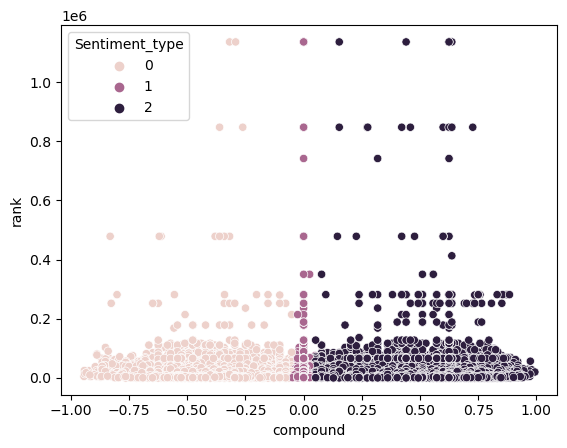

In [44]:
sns.scatterplot(x=df['compound'],y=df['rank'],hue=df['Sentiment_type'],data=df)

In [45]:
df_clu=df[['compound','rank']]   # Taking only compound and price column
df_clu

,compound,rank
8379,0.3804,22044.0
10763,0.4404,30956.0
10928,-0.2732,76431.0
7606,0.7845,24985.0
10757,0.3182,18334.0
...,...,...
51921,0.6249,996.0
51920,-0.4215,996.0
51918,0.7003,996.0
51919,0.0000,996.0


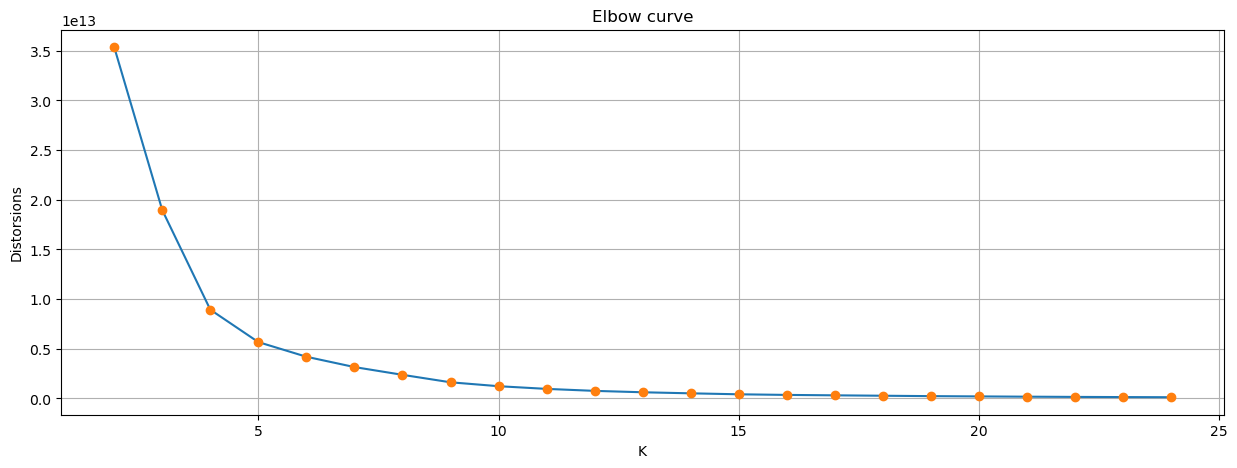

In [46]:
kk=[]                                    # empty list created
distorsions = []                         # empty list created
for k in range(2, 25):
    kmeans = KMeans(n_clusters=k)        # kmean lib is used 
    kmeans.fit(df_clu)
    distorsions.append(kmeans.inertia_)
    kk.append(k)
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 25), distorsions)
plt.plot(kk,distorsions,'o')
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Distorsions')
plt.title('Elbow curve');

In [47]:
cluster_model = KMeans(n_clusters=5)   # best silhoutte score 
pre_cluster=cluster_model.fit_predict(df_clu)
pre_cluster

array([2, 2, 4, ..., 0, 0, 0])

In [48]:
df['cluster_pre']=pre_cluster

In [49]:
df['cluster_pre'].unique()

array([2, 4, 0, 1, 3])

In [50]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,review,Number_of_Words_in_review,...,brand,rank,main_cat,price,image_uploaded,compound,Sentiment_type,rev_word_count,unique_word_count,cluster_pre
8379,5,False,1999-11-03,A3GKHCZR2K6RC,B00001IVRD,James Birkett,the main thing about the games i love is the g...,i think for the price it s a must really cool,the main thing about the games i love is the g...,57,...,vivendi universal,22044.0,Video Games,52.77,yes,0.3804,2,11,11,2
10763,5,False,1999-11-10,A1QA8K3LD9K892,B000021Y5Q,Chris Adamson,this is the football game to play with friends...,easy to learn football hijinks,this is the football game to play with friends...,81,...,midway,30956.0,Video Games,82.06,no,0.4404,2,5,5,2
10928,3,False,1999-11-10,A1QA8K3LD9K892,B000021Y5V,Chris Adamson,the graphics are mediocre the fog and pop up a...,disappointing but servicable,the graphics are mediocre the fog and pop up a...,69,...,midway,76431.0,Video Games,42.99,yes,-0.2732,0,3,3,4
7606,2,False,1999-11-10,A1QA8K3LD9K892,B00000K1V2,Chris Adamson,plodding first person shooter with tons of fog...,a party rental at best,plodding first person shooter with tons of fog...,60,...,acclaim,24985.0,Video Games,87.95,yes,0.7845,2,5,5,2
10757,5,False,1999-11-10,A1QA8K3LD9K892,B000021Y5F,Chris Adamson,williams made games for hard core arcade gamer...,a cool s artifact,williams made games for hard core arcade gamer...,87,...,williams,18334.0,Video Games,69.00,yes,0.3182,2,4,4,0


In [51]:
X = df.loc[:, ['rank', 'compound']].values  # here we are taking compound and price column
xx=pd.DataFrame(X)

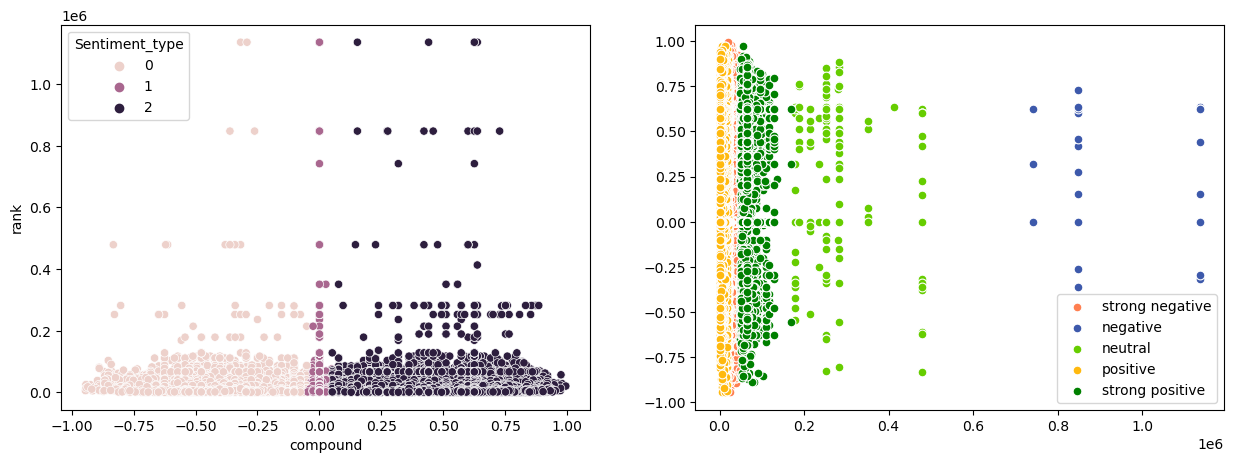

In [81]:
# both graph should be explained when new data is imported
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.scatterplot(df['compound'],df['rank'],hue=df['Sentiment_type'],c=cluster_model.predict(df_clu))
plt.subplot(122)
plt.scatter(X[pre_cluster == 2, 0], X[pre_cluster == 2, 1], s = 40 ,c = '#FF7F50',edgecolors='white',linewidth=0.8, label = 'strong negative')
plt.scatter(X[pre_cluster == 1, 0], X[pre_cluster == 1, 1], s = 40 ,c = '#3D59AB',edgecolors='white',linewidth=0.8, label = 'negative')
plt.scatter(X[pre_cluster == 3, 0], X[pre_cluster == 3, 1], s = 40 ,c = '#66CD00',edgecolors='white',linewidth=0.8, label = 'neutral')
plt.scatter(X[pre_cluster == 0, 0], X[pre_cluster == 0, 1], s = 40 ,c = '#FFB90F',edgecolors='white',linewidth=0.8, label = 'positive')
plt.scatter(X[pre_cluster == 4, 0], X[pre_cluster == 4, 1], s = 40 ,c = 'green',edgecolors='white',linewidth=0.8, label = 'strong positive')
plt.legend()
plt.show()

## TSA data

In [53]:
final=pd.read_csv("Final_Video_Games_data.csv", parse_dates=True,index_col ='reviewTime')
final=final.sort_values(by='reviewTime')
final.head(3)

,overall,verified,reviewerID,asin,reviewerName,reviewText,summary,review,Number_of_Words_in_review,Sentiment,category,description,title,brand,rank,main_cat,price,image_uploaded,compound
reviewTime,,,,,,,,,,,,,,,,,,,
1999-11-03,5,False,A3GKHCZR2K6RC,B00001IVRD,James Birkett,the main thing about the games i love is the g...,i think for the price it s a must really cool,the main thing about the games i love is the g...,57,positive,video games pc games,real time strategy goes to new levels as three...,StarCraft Battle Chest - PC/Mac,vivendi universal,22044.0,Video Games,52.77,yes,0.3804
1999-11-10,5,False,A1QA8K3LD9K892,B000021Y5Q,Chris Adamson,this is the football game to play with friends...,easy to learn football hijinks,this is the football game to play with friends...,81,positive,video games retro gaming microconsoles playsta...,nfl blitz is an arcade style football game fro...,NFL Blitz,midway,30956.0,Video Games,82.06,no,0.4404
1999-11-10,5,False,A1QA8K3LD9K892,B000021Y5F,Chris Adamson,williams made games for hard core arcade gamer...,a cool s artifact,williams made games for hard core arcade gamer...,87,positive,video games retro gaming microconsoles playsta...,used play station 1 william s arcade s greates...,William's Arcade's Greatest Hits,williams,18334.0,Video Games,69.00,yes,0.3182


In [54]:
df1=final[final['Sentiment']=='positive'] # featching data only for positive sentiment
df2=final[final['Sentiment']=='negetive'] # featching data only for negative sentiment
df3=final[final['Sentiment']=='neutral']  # featching data only for neutral sentiment
print("Positive:{} , Negative:{} , Neutral:{}".format(df1.shape,df2.shape,df3.shape)) # checking shape of all data 

Positive:(28203, 19) , Negative:(6892, 19) , Neutral:(20155, 19)


In [55]:
#function for resampleing the data into months then ploting its actual,trend, seasonality,residual plots with acf & pacf plot

def resample(data,lag):
    global data_s,data_w,d_seasonal,traint,testt,train,test
    
#resample data into months
    data_s=data.resample('m').mean()                                  
    
#imputing missing values with the help of interpolate
    data_s['overall'].interpolate(method="linear",inplace=True)
    data_s['Number_of_Words_in_review'].interpolate(method="linear",inplace=True)
    data_s['rank'].interpolate(method="linear",inplace=True)
    data_s['compound'].interpolate(method="linear",inplace=True)
    data_s=data_s[['overall','rank','Number_of_Words_in_review','compound']]
    
#filtering the dependent columns
    data_w=data_s.compound
    
    
#checking trend,seasonal and residual
    ts_comp=seasonal_decompose(data_w,period=12)

    d_trend=ts_comp.trend
    d_seasonal=ts_comp.seasonal
    d_residual=ts_comp.resid
#plot the actual,trend, seasonality,residual components
    fig,ax = plt.subplots(4,1,figsize=(20,12))
    plt.subplot(411)
    plt.plot(data_w,label='actual')
    plt.legend()
    plt.subplot(412)
    plt.plot(d_trend,label='Trend',c='red')
    plt.legend()
    plt.subplot(413)
    plt.plot(d_seasonal,label='Seasonal',c='g')
    plt.legend()
    plt.subplot(414)
    plt.plot(d_residual,label='Residual')
    plt.legend()
    
#Checking data is stationarity or not
    pvalue=adfuller(data_w)[1]
    print('Pvalue for data',pvalue)
    if pvalue < 0.05:
        print('Data is stationary. Proceed to model building\n')
    else:
        print('Data is not Stationary. Make the data stationary before model building\n')

        
#ploting ACF & PACF plot
    _,ax=plt.subplots(1,2,figsize=(14,8))

    plot_pacf(data_w,lags=lag,ax=ax[0],c='black');
    plot_acf(data_w,lags=lag,ax=ax[1],c='black');
    
#spliting our data into test train with 70% train and 30% test
    ss=int(len(data_w)*0.7)
    traint=data_s[:ss]
    testt=data_s[ss:]
    print('70% train data={},30% test data={}'.format(len(traint),len(testt)))
    train=traint.compound
    test=testt.compound
    print('70% train data={},30% test data={}'.format(len(train),len(test)))

    return data_s,data_w

In [56]:
#function for checking best (p,d,q & P,D,Q) values for sarimax model
def bestvalue(p,d,q,P,D,Q):
    global RMSE
    li=[]                      #Creating loop for various p,d,q values
    for i in range(p):
        for j in range(q):
            li.append((i,d,j))
    bi=[]
    for I in range(P):          #Creating loop for various P,D,Q values
        for J in range(Q):
            bi.append((I,D,J))
    ci=[]
    for i in (li):
        for j in(bi):
            ci.append((i,j))
    
    model1 = []
    for i in li:
        for j in bi:
            m1=SARIMAX(train,order=(i),seasonal_order=(j[0],j[1],j[2],12)).fit() #Building model for different values of p,d,q & P,D,Q
            model1.append(m1)
    RMSE=[]
    for i in model1:
        a=mean_squared_error(train,i.fittedvalues,squared=False)        #Cheking RMSE value for the model
        RMSE.append(a)                                                  #Appending RMSE value
    minrmse=RMSE.index(min(RMSE))
    print("Min RMSE at index:",minrmse)
    for i,j in enumerate(RMSE):
        print("RMSE values for the models at index: ",i,j)
    print('\nModel(p,d,q), (P, D, Q) at indexs:')
    for a,b in enumerate(ci):
        print(a,b)    
    #return minrmse

In [57]:
#Q1:what are exog feature means and what their another name?
#Ans: Exogenous features is also known as economatric similar to dependend variable but they are not same.
#If the variable is dependent on variable with in the model it is an endogenous.

def sarimax1(p,d,q,P,D,Q,lag):
    global aic1,bic1,mse1,m1,pred,exog_train,exog_test

#Creating exogenus features for sarimax model
    exog_train=traint[['overall','rank']]
    exog_test=testt[['overall','rank']]

#building SARIMAX model with p,d,q &P,D,Q values
    m1=SARIMAX(train,order=(p,d,q),seasonal_order=(P,D,Q,lag),exog=exog_train.values).fit() 
    summ=m1.summary()                #printing model summary
    aic1,bic1=m1.aic,m1.bic           #featching aic and bic values from model

#predition test data for model building    
    pred=m1.forecast(len(testt.compound),exog=exog_test.values) 
    
#creating dataframe for actual and predicted values 
    actual=[]
    pred1=[]
    for i in range(len(pred)):
        actual.append(test[i])
        pred1.append(pred[i])
    df1=pd.DataFrame({'Actual_data':actual,'Forecast_data':pred1})
#printing RMSE values for the model
    mse1=mean_squared_error(df1.Actual_data,df1.Forecast_data)
    
#checking our model with ljungbox test weather its good or not.
    pvalue=sm.stats.acorr_ljungbox(m1.resid,lags=[1],return_df=True).lb_pvalue.values
    if pvalue < 0.05:
        print('Reject H0. Bad Model')
    else:
        print('Fail to reject H0. Hence the selected model is good model')
    print("RMSE value for the model:",mse1)
    print("\n\n-----------------------------------------Model Summary:---------------------------------------------\n")
    
#ploting actual test data and predicted forecast data
    df1.Actual_data.plot(figsize=(10,8),legend=True)
    df1.Forecast_data.plot(legend=True)
    plt.title('Actual test data and its Forecast ')
    return summ,df1,pvalue

In [58]:
#function for ploting actual,predicted forecast and future forecast
def Futureplot(value):  
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(data_s.compound, label='Actual')  #plot actual data
    ax.plot(pred, label='Predicted')          #plot predicted forecast data
    ax.plot(fcast, label='Future')            #plot future forecast data
    plt.xlabel('Months',fontsize=16)
    leg = ax.legend(fontsize=15)
    plt.title('Actual  / Predicted / Future',fontsize=16)
    plt.ylabel('Sentiment score',fontsize=16)

# ---------------------------------------Positive Sentiment---------------------------------------

Pvalue for data 0.0020658570217573363
Data is stationary. Proceed to model building

70% train data=156,30% test data=67
70% train data=156,30% test data=67


(             overall           rank  Number_of_Words_in_review  compound
 reviewTime                                                              
 1999-11-30  4.333333   20709.666667                      77.00  0.538483
 1999-12-31  4.666667   11372.000000                      72.00  0.483900
 2000-01-31  4.000000   40917.250000                     301.25  0.496675
 2000-02-29  5.000000  102439.000000                     232.00  0.440400
 2000-03-31  4.400000   22226.800000                     175.00  0.564480
 ...              ...            ...                        ...       ...
 2018-01-31  4.833333    2396.111111                      35.50  0.519850
 2018-02-28  4.307692     549.615385                      45.00  0.531392
 2018-03-31  4.400000     996.000000                      40.20  0.405400
 2018-04-30  2.750000     996.000000                      73.00  0.679700
 2018-05-31  5.000000     996.000000                      11.00  0.700300
 
 [223 rows x 4 columns],
 reviewTime

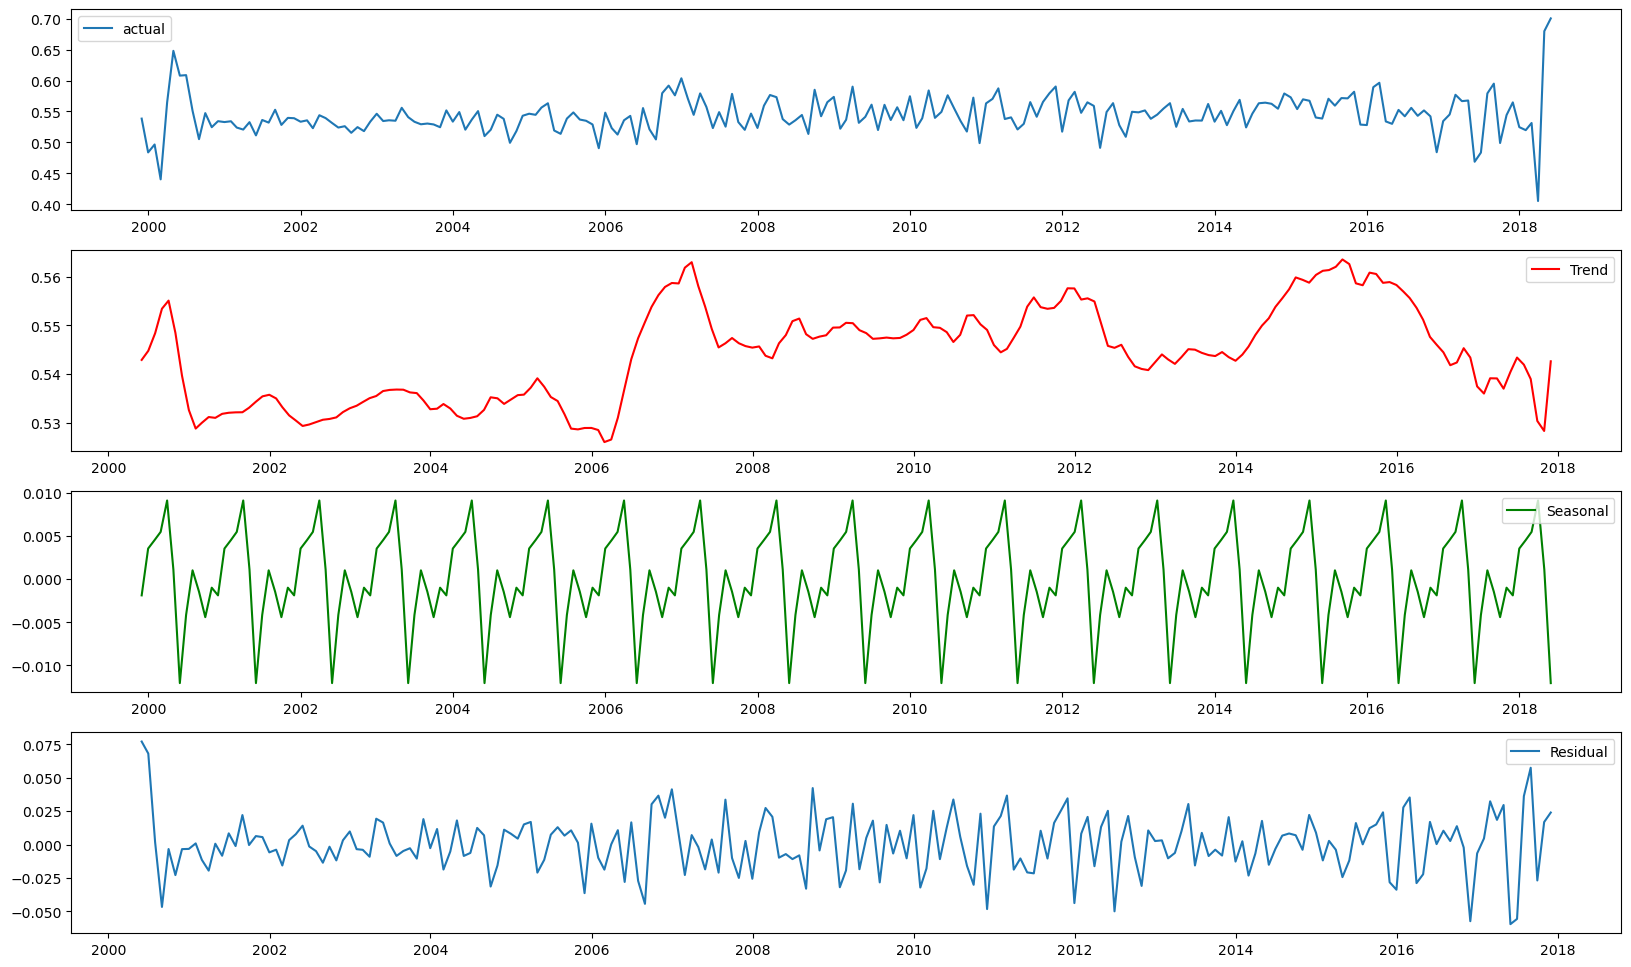

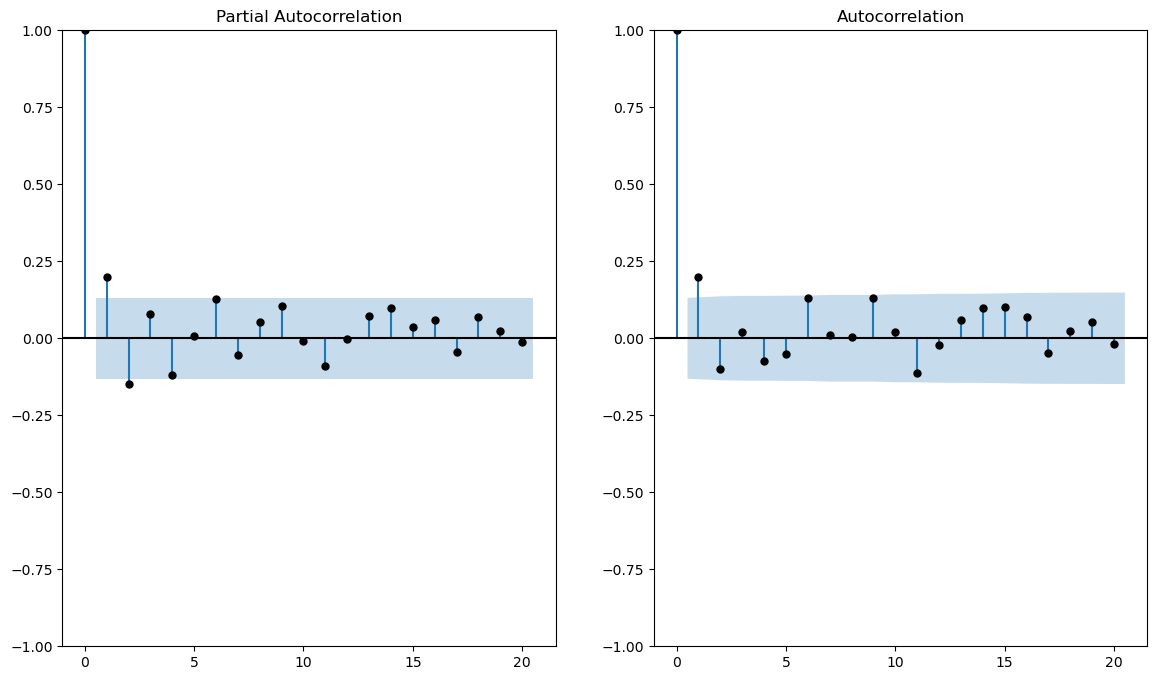

In [59]:
resample(df1,20)

In [60]:
bestvalue(2,0,1,2,0,2)

Min RMSE at index: 7
RMSE values for the models at index:  0 0.5424853829177104
RMSE values for the models at index:  1 0.3213228302689164
RMSE values for the models at index:  2 0.15493523941174228
RMSE values for the models at index:  3 0.1542119551705378
RMSE values for the models at index:  4 0.05363776501535175
RMSE values for the models at index:  5 0.053632074947878694
RMSE values for the models at index:  6 0.05363274985632029
RMSE values for the models at index:  7 0.053613641883249796

Model(p,d,q), (P, D, Q) at indexs:
0 ((0, 0, 0), (0, 0, 0))
1 ((0, 0, 0), (0, 0, 1))
2 ((0, 0, 0), (1, 0, 0))
3 ((0, 0, 0), (1, 0, 1))
4 ((1, 0, 0), (0, 0, 0))
5 ((1, 0, 0), (0, 0, 1))
6 ((1, 0, 0), (1, 0, 0))
7 ((1, 0, 0), (1, 0, 1))


Fail to reject H0. Hence the selected model is good model
RMSE value for the model: 0.0031130722919772294


-----------------------------------------Model Summary:---------------------------------------------



C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(<class 'statsmodels.iolib.summary.Summary'>
 """
                                       SARIMAX Results                                       
 Dep. Variable:                             compound   No. Observations:                  156
 Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 345.550
 Date:                              Wed, 05 Apr 2023   AIC                           -679.100
 Time:                                      09:44:29   BIC                           -660.801
 Sample:                                  11-30-1999   HQIC                          -671.668
                                        - 10-31-2012                                         
 Covariance Type:                                opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 x1             0.1238      0.001    1

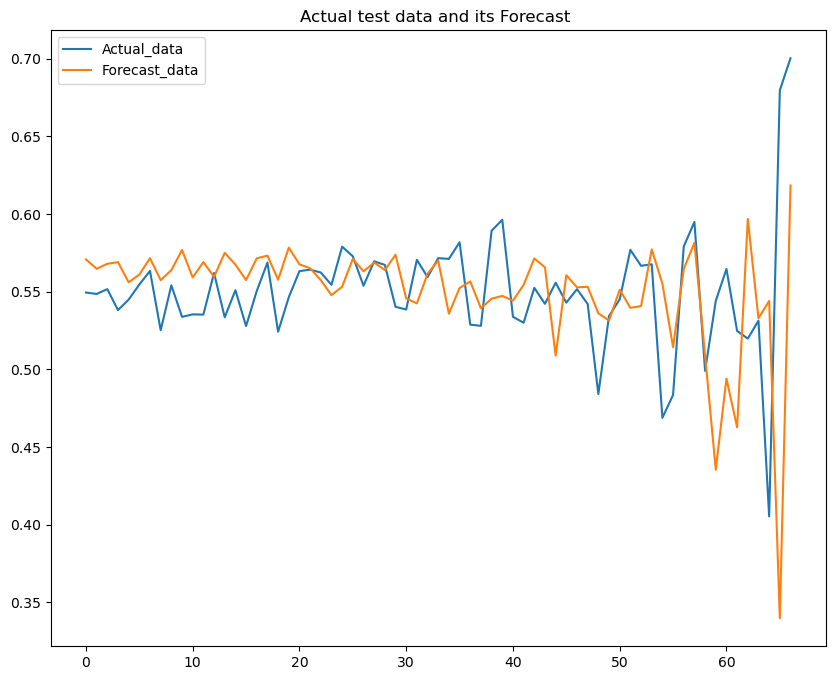

In [61]:
sarimax1(1,0,0,1,0,1,12)

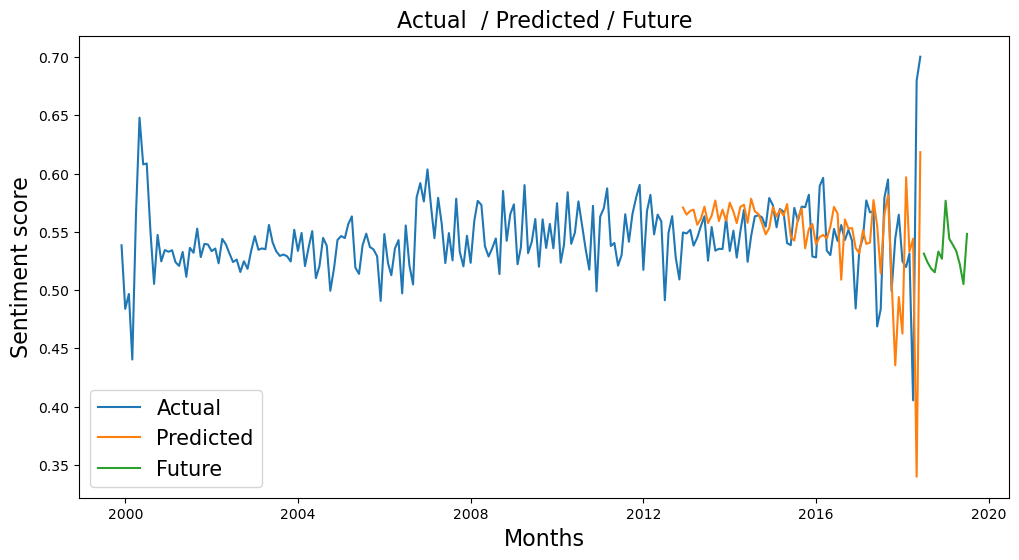

In [62]:
#Done future forecast of data we had given for resample
fcast = m1.predict(len(data_w),len(data_w)+12,exog=exog_train[:80])
#Plot actual,predicted forecast and future forecast data
Futureplot(47)

# ---------------------------------------Negative Sentiment----------------------------------------

Pvalue for data 1.7250784530619644e-10
Data is stationary. Proceed to model building

70% train data=155,30% test data=67
70% train data=155,30% test data=67


(             overall           rank  Number_of_Words_in_review  compound
 reviewTime                                                              
 1999-11-30  4.000000   49237.500000                  51.500000 -0.273200
 1999-12-31  4.000000  117092.559513                  56.000000 -0.493900
 2000-01-31  1.000000  102439.000000                 265.000000 -0.341200
 2000-02-29  1.500000   79485.000000                 208.750000 -0.371550
 2000-03-31  2.000000   56531.000000                 152.500000 -0.401900
 ...              ...            ...                        ...       ...
 2017-12-31  1.625000    2693.625000                  42.500000 -0.495225
 2018-01-31  1.000000     996.000000                  56.000000 -0.296000
 2018-02-28  1.000000    1283.857143                  41.000000 -0.466214
 2018-03-31  1.166667     910.000000                  79.666667 -0.420367
 2018-04-30  1.333333     996.000000                  48.666667 -0.474967
 
 [222 rows x 4 columns],
 reviewTime

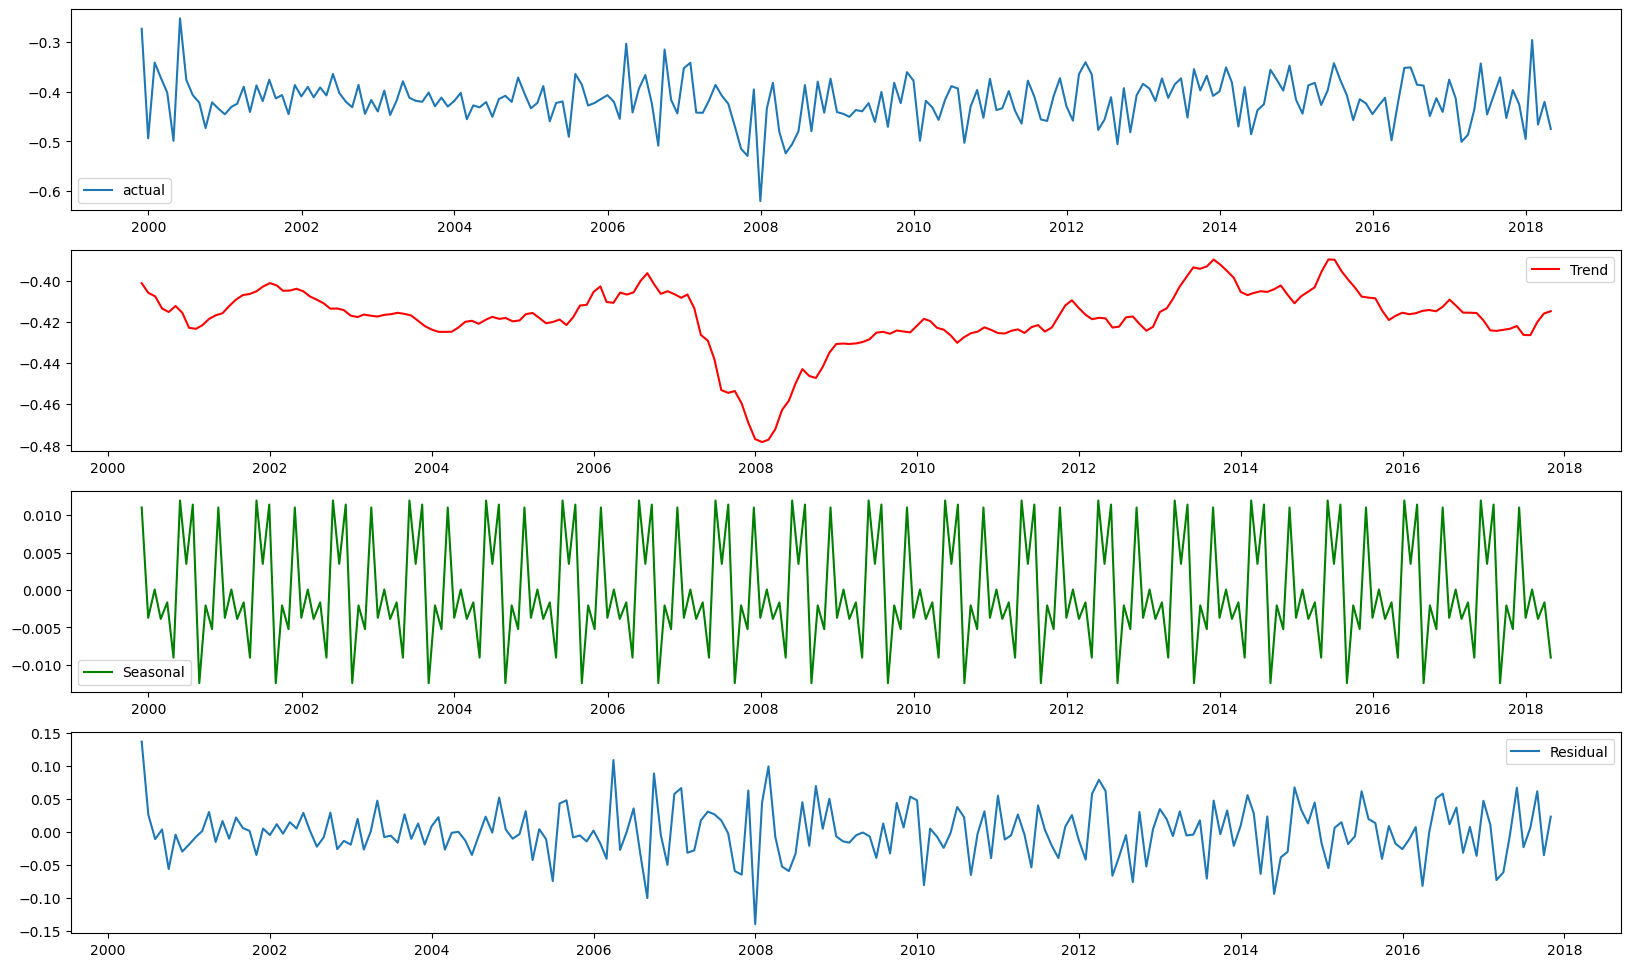

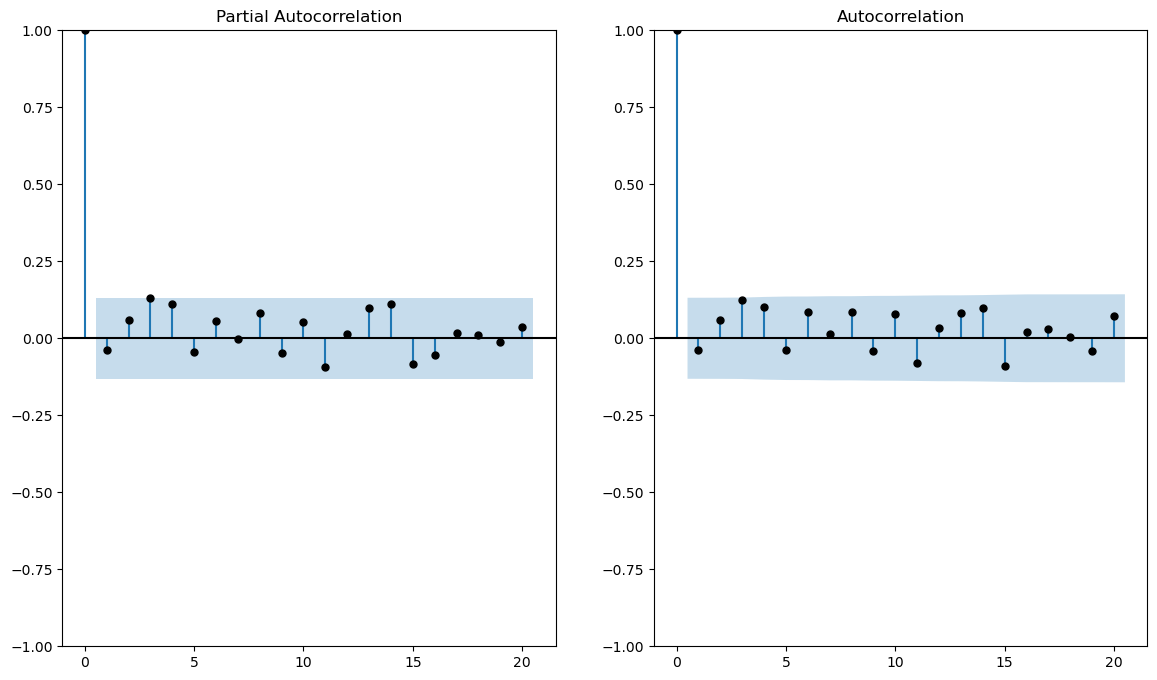

In [63]:
resample(df2,20)

In [64]:
bestvalue(3,0,1,2,0,2)

Min RMSE at index: 11
RMSE values for the models at index:  0 0.4227192494422718
RMSE values for the models at index:  1 0.2579165668707298
RMSE values for the models at index:  2 0.1265039824233177
RMSE values for the models at index:  3 0.12209626399976956
RMSE values for the models at index:  4 0.06980718475123367
RMSE values for the models at index:  5 0.06961453579567937
RMSE values for the models at index:  6 0.06958666138902012
RMSE values for the models at index:  7 0.06878567032141056
RMSE values for the models at index:  8 0.060847317607920025
RMSE values for the models at index:  9 0.06083574115730042
RMSE values for the models at index:  10 0.0608501052442271
RMSE values for the models at index:  11 0.06078182597962257

Model(p,d,q), (P, D, Q) at indexs:
0 ((0, 0, 0), (0, 0, 0))
1 ((0, 0, 0), (0, 0, 1))
2 ((0, 0, 0), (1, 0, 0))
3 ((0, 0, 0), (1, 0, 1))
4 ((1, 0, 0), (0, 0, 0))
5 ((1, 0, 0), (0, 0, 1))
6 ((1, 0, 0), (1, 0, 0))
7 ((1, 0, 0), (1, 0, 1))
8 ((2, 0, 0), (0, 0, 0)

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fail to reject H0. Hence the selected model is good model
RMSE value for the model: 0.022673462270094903


-----------------------------------------Model Summary:---------------------------------------------



C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(<class 'statsmodels.iolib.summary.Summary'>
 """
                                       SARIMAX Results                                       
 Dep. Variable:                             compound   No. Observations:                  155
 Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 186.410
 Date:                              Wed, 05 Apr 2023   AIC                           -358.820
 Time:                                      09:44:34   BIC                           -337.516
 Sample:                                  11-30-1999   HQIC                          -350.166
                                        - 09-30-2012                                         
 Covariance Type:                                opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 x1            -0.1165      0.004    -

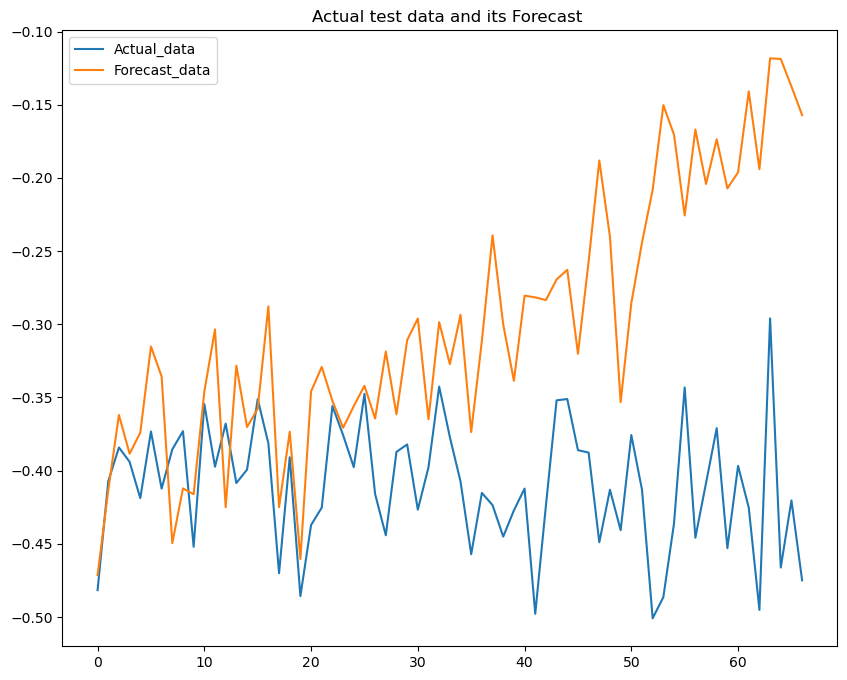

In [65]:
sarimax1(2,0,0,1,0,1,12)

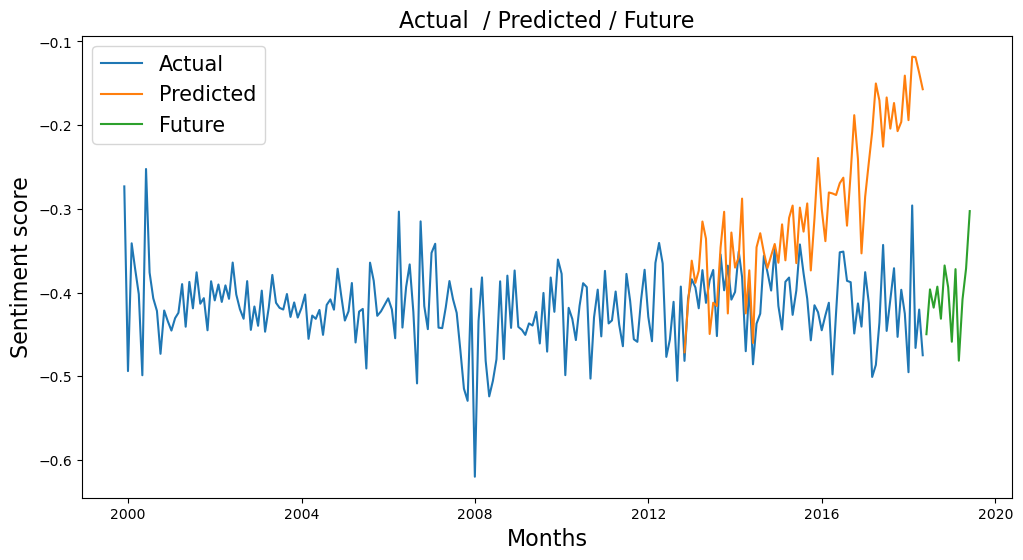

In [66]:
#Done future forecast of data we had given for resample
fcast = m1.predict(len(data_w),len(data_w)+12,exog=exog_train[:80])


#Plot actual,predicted forecast and future forecast data
Futureplot(47)

# ----------------------------------------Neutral Sentiment-----------------------------------------

Pvalue for data 9.768437517288253e-13
Data is stationary. Proceed to model building

70% train data=156,30% test data=67
70% train data=156,30% test data=67


(             overall           rank  Number_of_Words_in_review  compound
 reviewTime                                                              
 1999-11-30  4.000000   22044.000000                  69.000000       0.0
 1999-12-31  5.000000  244615.000000                 100.500000       0.0
 2000-01-31  5.000000  117092.559513                  68.000000       0.0
 2000-02-29  1.000000   35479.000000                 197.000000       0.0
 2000-03-31  5.000000   94689.000000                  46.500000       0.0
 ...              ...            ...                        ...       ...
 2018-01-31  3.617647    1759.617647                  13.617647       0.0
 2018-02-28  3.000000    1471.533333                  21.666667       0.0
 2018-03-31  2.944444     717.055556                  14.944444       0.0
 2018-04-30  1.000000     996.000000                   9.666667       0.0
 2018-05-31  5.000000     996.000000                  12.000000       0.0
 
 [223 rows x 4 columns],
 reviewTime

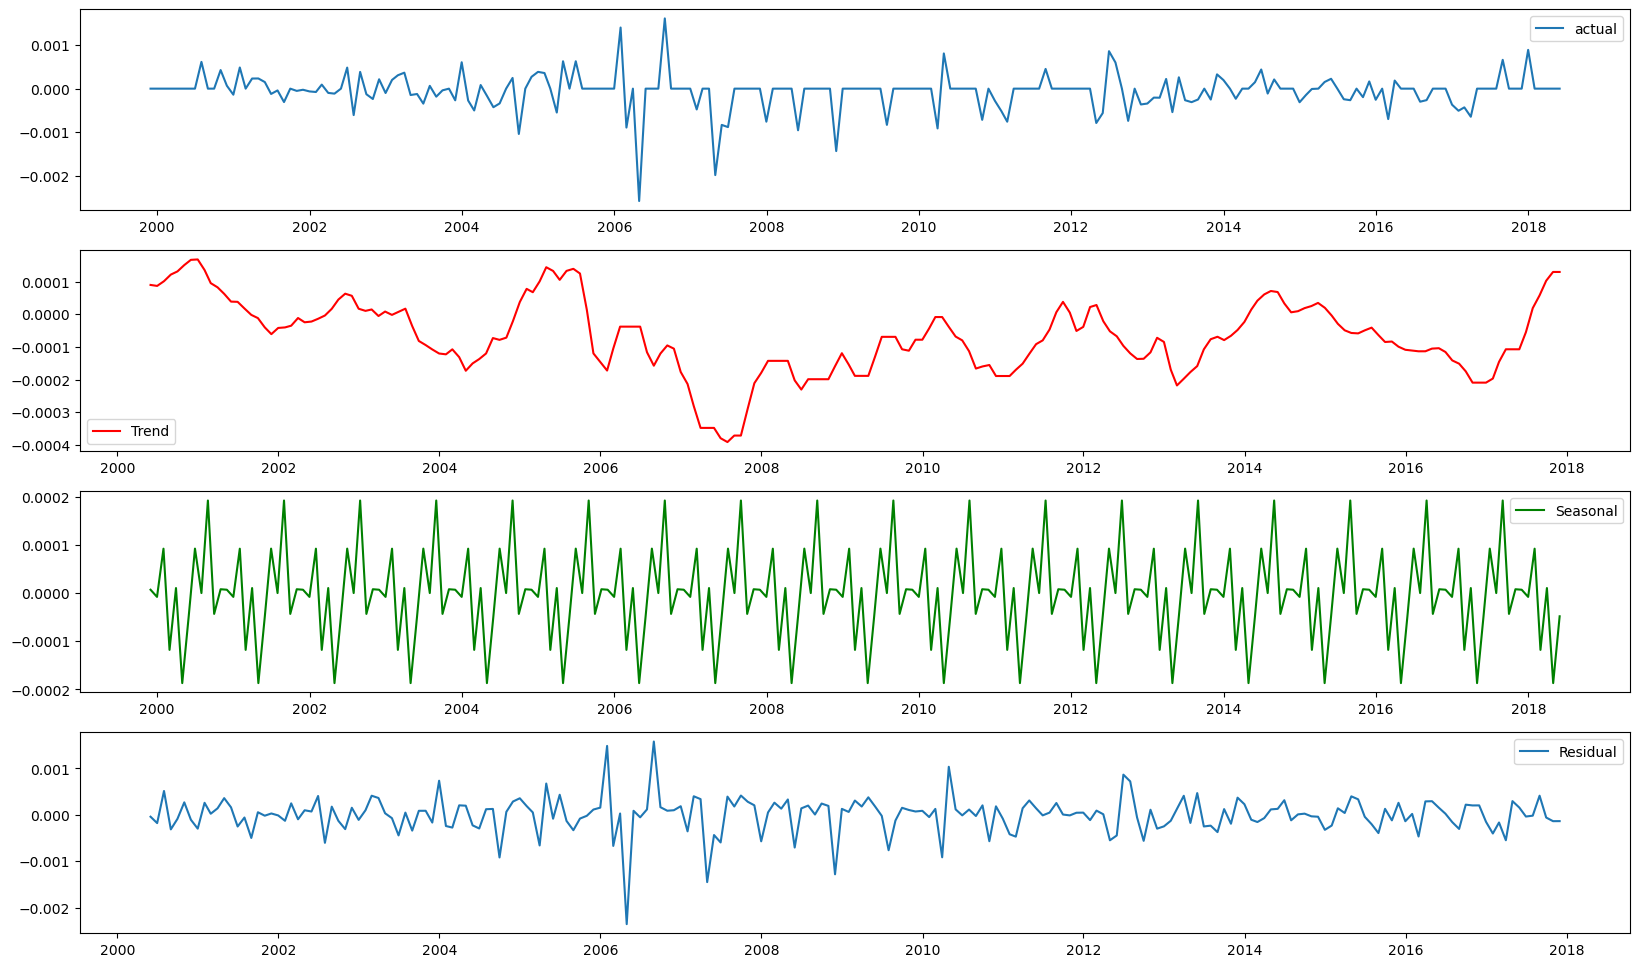

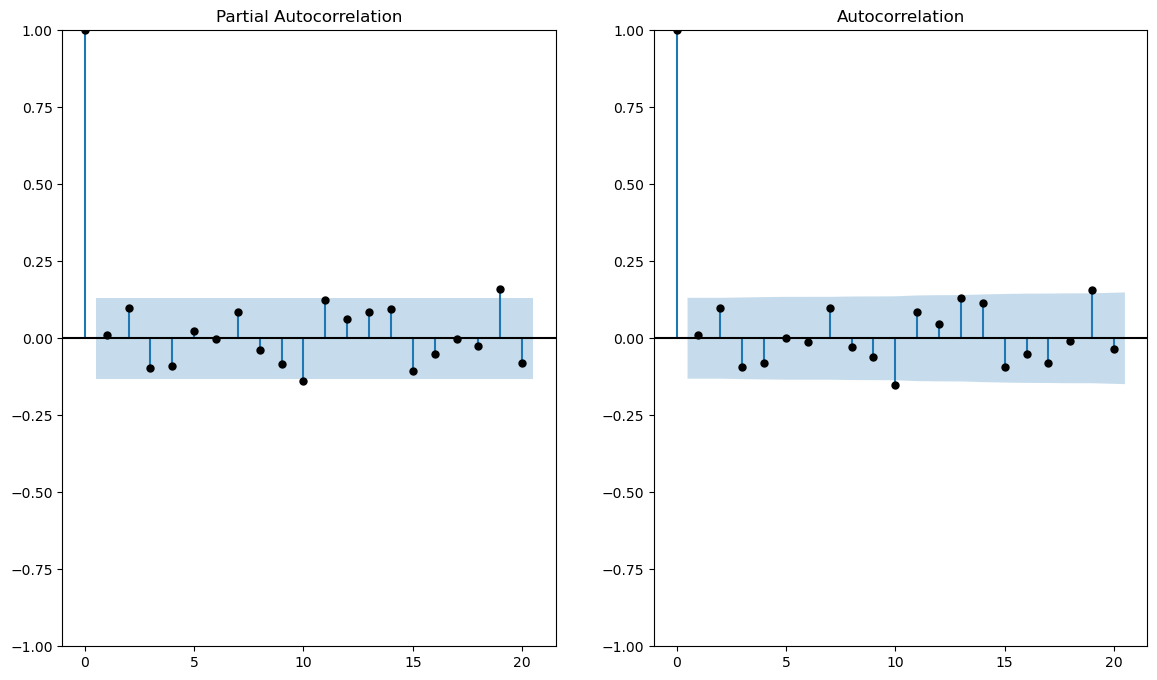

In [67]:
resample(df3,20)

In [68]:
bestvalue(5,0,3,2,0,2)

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Lik

Min RMSE at index: 58
RMSE values for the models at index:  0 0.0004650466722443642
RMSE values for the models at index:  1 0.00046541733277899146
RMSE values for the models at index:  2 0.000462812617599691
RMSE values for the models at index:  3 0.00046541549220458064
RMSE values for the models at index:  4 0.00046501517390036464
RMSE values for the models at index:  5 0.0004653589700465292
RMSE values for the models at index:  6 0.0004631212949839319
RMSE values for the models at index:  7 0.00046533997425466067
RMSE values for the models at index:  8 0.0004622834165606294
RMSE values for the models at index:  9 0.0004626199267772972
RMSE values for the models at index:  10 0.00046042576465040125
RMSE values for the models at index:  11 0.0004625301342941937
RMSE values for the models at index:  12 0.0004649788839245131
RMSE values for the models at index:  13 0.0004653301083487589
RMSE values for the models at index:  14 0.0004629879677212987
RMSE values for the models at index:  1

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fail to reject H0. Hence the selected model is good model
RMSE value for the model: 7.021999253677001e-08


-----------------------------------------Model Summary:---------------------------------------------



C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(<class 'statsmodels.iolib.summary.Summary'>
 """
                                       SARIMAX Results                                      
 Dep. Variable:                            compound   No. Observations:                  156
 Model:             SARIMAX(4, 0, 2)x(1, 0, [], 12)   Log Likelihood                 979.809
 Date:                             Wed, 05 Apr 2023   AIC                          -1939.619
 Time:                                     09:44:52   BIC                          -1909.120
 Sample:                                 11-30-1999   HQIC                         -1927.232
                                       - 10-31-2012                                         
 Covariance Type:                               opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 x1         -1.705e-05    2.1e-05     -0.812  

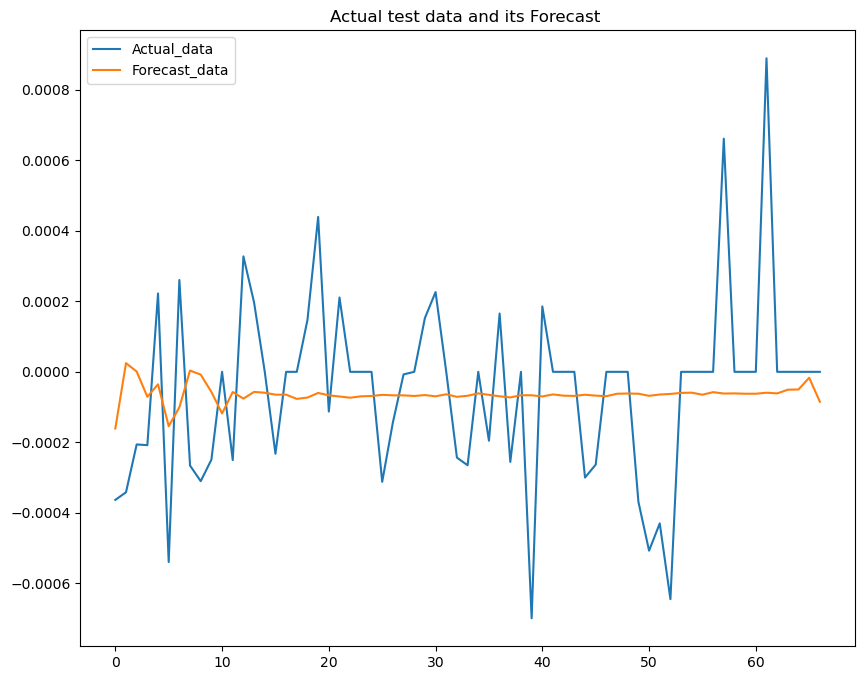

In [69]:
sarimax1(4,0,2,1,0,0,12)

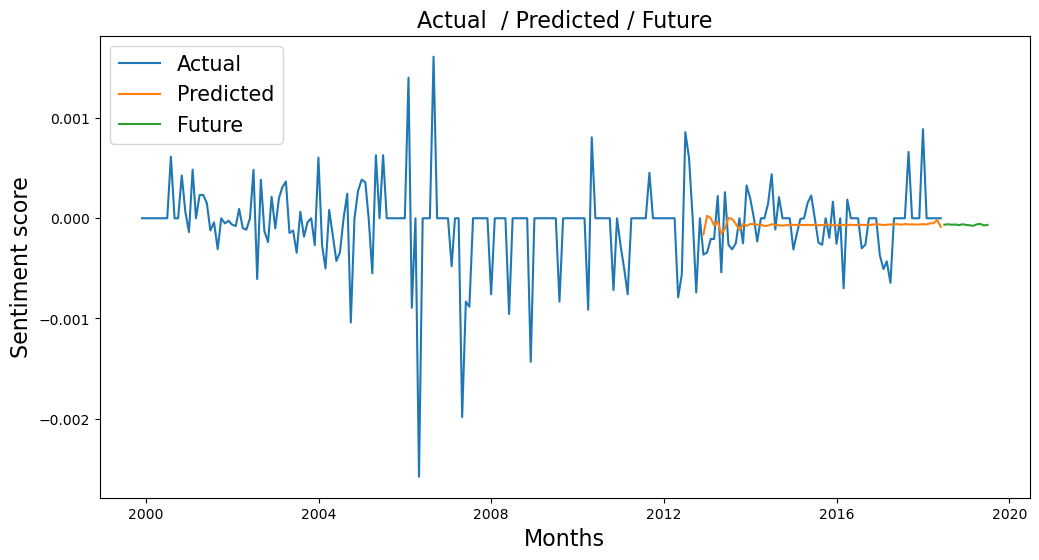

In [70]:
#Done future forecast of data we had given for resample
fcast = m1.predict(len(data_w),len(data_w)+12,exog=exog_train[:80])


#Plot actual,predicted forecast and future forecast data
Futureplot(47) 